**Лабораторная работа №5**


> Линейные модели, SVM и деревья решений.


Цель лабораторной работы: изучение линейных моделей, SVM и деревьев решений.

#Подключение библиотек и первичная настройка

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from graphviz import Digraph

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install graphviz   #впоследствии не получилось воспользоваться из-за возникнувшей ошибки
!pip install pydotplus

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Задание 1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
Контекст
Этот набор данных создан для прогнозирования поступления выпускников с индийской точки зрения.

Содержание
Набор данных содержит несколько параметров, которые считаются важными при подаче заявки на магистерские программы.
Параметры являются следующими :

* GRE Scores ( out of 340 )
* TOEFL Scores ( out of 120 )
* University Rating ( out of 5 )
* Statement of Purpose and Letter of Recommendation
* Strength ( out of 5 )
* Undergraduate GPA ( out of 10 )
* Research Experience ( either 0 or 1 )
* Chance of Admit ( ranging from 0 to 1 )

* В датасете отсутствуют пробелы;
* В названиях двух колонок присутствуют пробелы, которые  необходимо будет убрать;

In [0]:
data1 = pd.read_csv('/content/drive/My Drive/MMO_Datasets/Admission.csv', sep=',')

In [5]:
strippedCols = dict()
for name in data1.columns:
  strippedCols[name] = name.strip() 
data1 = data1.rename(strippedCols, axis='columns', errors='raise')
data1.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


**Задание 2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.**

In [6]:
data1.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

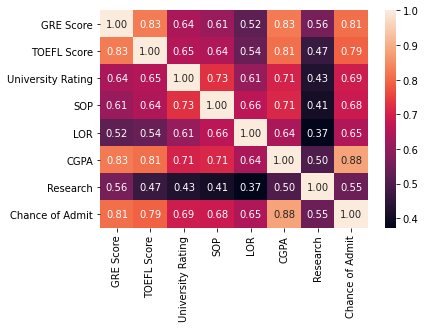

In [7]:
import seaborn as sbrn
sbrn.heatmap(data1[data1.columns[1:]].corr(), annot=True, fmt='.2f')

В качестве целевого параметра будем использовать шансы кандидата на поступление - `Chance of Admit`. Самый наибольший коффициент корреляции с переменной `CGPA`

# Задание 4. Обучите следующие модели:
* одну из линейных моделей;
* SVM;
* дерево решений.

##Линейная модель

**Цель построения модели**: Определение значения целевой переменной (`Chance of Admit` - шанс на поступление кандидата) от значения переменной `CGPA` (оценка за бакалавриат GPA).

**Разделение выборки и построение линейной модели**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1['CGPA'], \
                                                   data1['Chance of Admit'], \
                                                   test_size=0.3, \
                                                   random_state=42)

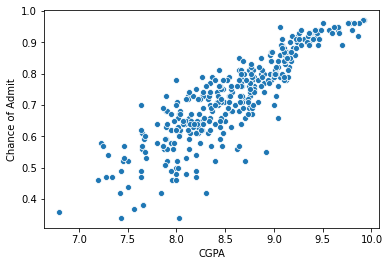

In [9]:
sbrn.scatterplot(x=X_train, y=y_train)

In [0]:
x_array = X_train
y_array = y_train

Аналитически восстановим зависимость

In [0]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray):
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [12]:
b0, b1 = analytic_regr_coef(x_array= x_array, y_array= y_array )
print ('Коэффициенты, полученные аналитически:\nb0 = ', b0, '\nb1 = ', b1)

Коэффициенты, полученные аналитически:
b0 =  -1.0441352652694436 
b1 =  0.20617424104989948


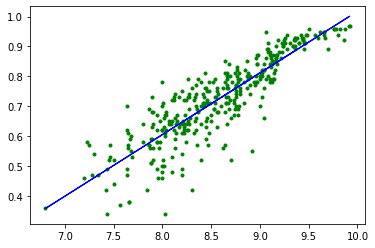

In [13]:
y_array_regr = y_regr( x_array, b0, b1)
plt.plot( x_array, y_array, 'g.')
plt.plot( x_array, y_array_regr, 'b', linewidth=1.2)
plt.show()

В качестве метода регуляризации линейной регрессии будем использовать L2 регуляризацию:

![alt text](https://sun9-6.userapi.com/A-CS6mtZC6D30UGgTVHmLvk__KnJH-MwgtBtUg/rDLQfJdF0G8.jpg)

В качестве гиперпараметра модели будем использовать коэффициент регуляризации.


In [0]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Метод создания модели линейной регрессии с применением 
# гребневой регуляризации на обучающей выборке.
# Проверка качества модели на тестовой выборке.
def RidgeLinearRegression( alpha,\
                           X_train,\
                           X_test, \
                           y_train, \
                           y_test):
  print('Linear Regression. Ridge regulariztaion')
  print('Alpha=', alpha)
  print ('Theoretical\tb0=', b0, '\tb1=', b1)
  reg4 = Ridge( alpha=alpha ).fit(  np.array(X_train).reshape(-1, 1), np.array(y_train) )
  print('Results   \tb0=', reg4.intercept_, ' \tb1=', reg4.coef_)
  predictResults=reg4.predict(X=np.array(X_test).reshape(-1,1) )
  print('MSE: \t', mean_squared_error(y_test, predictResults))
  print('MAE: \t', mean_absolute_error(y_test, predictResults))
  print('R2: \t', r2_score(y_true=np.array(y_test), y_pred=predictResults ))
  return reg4

Обучение модели с коэффициентом регуляризации равным 10.

In [15]:
testLR = RidgeLinearRegression(10, X_train, X_test, y_train, y_test)

Linear Regression. Ridge regulariztaion
Alpha= 10
Theoretical	b0= -1.0441352652694436 	b1= 0.20617424104989948
Results   	b0= -0.911698261998257  	b1= [0.19073211]
MSE: 	 0.004389331192428343
MAE: 	 0.0465762650745534
R2: 	 0.789400341212476


**Поиск наилучшего гиперпараметра. Применение кросс-валидации и решетчатого поиска**


In [0]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

В качестве метода кросс-валидации будем использовать Shuffle Split - случайное "перемешивание" выборки.

In [0]:
kf = ShuffleSplit(n_splits=5, test_size=0.3).split(data1['CGPA'], data1['Chance of Admit'])

Гиперпараметр будет изменяться от 0.1 до 11 с шагом 0.1 

In [18]:
n_range = np.array(np.arange(0.1 ,11. ,0.1 ))
tuned_parameters = [{'alpha': n_range}]
tuned_parameters

[{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
          1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
          2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
          3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
          4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
          5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
          6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
          7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
          8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
         10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9])}]

В качестве параметра оценки качества модели будем использовать MSE

In [19]:
clf_gs = GridSearchCV(Ridge(), tuned_parameters, cv=kf, scoring='neg_mean_squared_error')
clf_gs.fit(np.array(data1['CGPA']).reshape(-1,1), np.array(data1['Chance of Admit']).reshape(-1,1) )

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f7095fb2f68>,
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,...
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9])}],
             pre_dispatch='2*n_jobs', 

In [20]:
clf_gs.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [21]:
clf_gs.best_score_

-0.004559796848772596

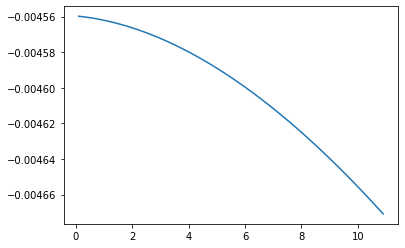

In [22]:
import matplotlib.pyplot as pyplot
pyplot.plot(n_range, clf_gs.cv_results_['mean_test_score'])

Таким образом, наилучшее качество модели достигается при Гиперпараметре равном 0.1. Увеличение гиперпараметра способствует увеличению MSE. 

**Сравнение моделей**

In [23]:
testLR = RidgeLinearRegression(10, X_train, X_test, y_train, y_test)
print('\n')
optimalLR = RidgeLinearRegression(0.1, X_train, X_test, y_train, y_test)

Linear Regression. Ridge regulariztaion
Alpha= 10
Theoretical	b0= -1.0441352652694436 	b1= 0.20617424104989948
Results   	b0= -0.911698261998257  	b1= [0.19073211]
MSE: 	 0.004389331192428343
MAE: 	 0.0465762650745534
R2: 	 0.789400341212476


Linear Regression. Ridge regulariztaion
Alpha= 0.1
Theoretical	b0= -1.0441352652694436 	b1= 0.20617424104989948
Results   	b0= -1.0427048291681977  	b1= [0.20600745]
MSE: 	 0.004304930211816103
MAE: 	 0.04556950135904033
R2: 	 0.7934498915742559


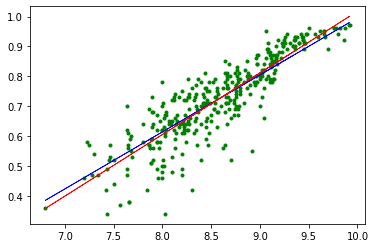

In [24]:
regrOld = y_regr( x_array, testLR.intercept_, testLR.coef_)
regrNew = y_regr( x_array, optimalLR.intercept_, optimalLR.coef_)
plt.plot( x_array, y_array, 'g.')
plt.plot( x_array, regrOld, 'b', linewidth=0.8)
plt.plot( x_array, regrNew, 'r', linewidth=0.8)
plt.show()


**Вывод:** Таким образом, с помощью решетчатого поиска и кросс-валидации удалось подобрать наиболее оптимальный гиперпараметр для построения линейной регрессии с L2 регуляризацией. Несмотря на то, что построенная раннее модель имеет высокую точность, подобранная модель имеет точность выше (показатель среднего квадрата ошибки хоть и отличается в 6 знаке после запятой, но все равно меньше). Наиболее оптимальный гиперпараметр альфа = 0.1

## SVM

**Цель построения модели**: Предсказание наличия у кандидата исследовательского опыта (переменная `Research`) от количества баллов по тестированию GRE (переменная `GRE Score`) и баллов бакалавриата GPA (переменная `CGPA`).

In [0]:
highLevel = data1[data1['Research'] == 1]
lowLevel = data1[data1['Research'] == 0]

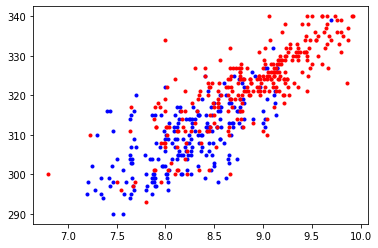

In [26]:
plt.plot( lowLevel['CGPA'], lowLevel['GRE Score'], 'b.')
plt.plot( highLevel['CGPA'], highLevel['GRE Score'], 'r.')

На графике красным отмечены кандидаты с исследовательским опытом работы, тогда как синим - без него.

In [27]:
data1[['CGPA', 'GRE Score']].describe()

,CGPA,GRE Score
count,500.000000,500.000000
mean,8.576440,316.472000
std,0.604813,11.295148
min,6.800000,290.000000
25%,8.127500,308.000000
50%,8.560000,317.000000
75%,9.040000,325.000000
max,9.920000,340.000000


Однако, перед началом построения модели необходимо выполнить  масштабирование, так как выбранные переменные распределены в различных пределах. Масштабирование существенно влияет на качество моделей SVM.

**Масштабирование данных**

In [0]:
from sklearn.preprocessing import MinMaxScaler
data2 = data1[['CGPA', 'GRE Score', 'Research']]
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data2)

In [29]:
data3 = pd.DataFrame(data=sc1_data, columns=data2.columns.values)
data3.head()

,CGPA,GRE Score,Research
0,0.913462,0.94,1.0
1,0.663462,0.68,1.0
2,0.384615,0.52,1.0
3,0.599359,0.64,1.0
4,0.451923,0.48,0.0


**Разделение выборки и построение модели**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data3[['CGPA', 'GRE Score']], \
                                                   data3['Research'], \
                                                   test_size=0.3, \
                                                   random_state=42)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
# Методы визуализации
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(np.array(X_train), \
            np.array(y_train))
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = X_train.iloc[:,0], X_train.iloc[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1,c=y_train,  cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('CGPA')
    ax.set_ylabel('GRE Score')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [32]:
X_train

,CGPA,GRE Score
5,0.814103,0.80
116,0.583333,0.18
45,0.737179,0.64
16,0.608974,0.54
462,0.365385,0.34
...,...,...
106,0.762821,0.78
270,0.455128,0.32
348,0.144231,0.24
435,0.282051,0.38


После того, как добавлены методы визуализации, необходимо обучить модель и вычислить метрики для оценки ее качества. В качестве гиперпараметра будем использовать коэффициент регуляризации. В качестве метрики СКО.

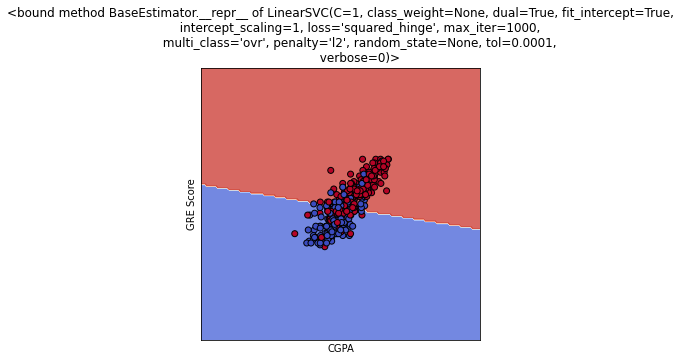


MSE: 0.23333333333333334


In [33]:
from sklearn.svm import LinearSVC
SvrModel = LinearSVC(C=1, max_iter=1000)
plot_cl(SvrModel)
SvrModel.fit(X_train, y_train)
y_pred = SvrModel.predict( np.array(X_test) )
print('\nMSE:',  mean_squared_error(y_test, y_pred))

Была построена модель с гиперпараметром С=1. СКО = 2,(3). Для того, чтобы улучшить качество модели, необходимо подобрать гиперпараметр С с импользованием кросс-валидации и решетчатого поиска.


**Поиск наилучшего гиперпараметра. Применение кросс-валидации и решетчатого поиска**


In [0]:
kf = ShuffleSplit(n_splits=5, test_size=0.3).split(data3[['CGPA', 'GRE Score']], data3['Research'])

In [35]:
n_range = np.array(np.arange(0.1 ,5 ,0.05 ))
tuned_parameters = [{'C': n_range}]
tuned_parameters

[{'C': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
         0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
         1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
         1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25,
         2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 ,
         2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35,
         3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 ,
         3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45,
         4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95])}]

In [36]:
clf_gs = GridSearchCV(LinearSVC(max_iter= 10000), tuned_parameters, cv=kf, scoring='neg_mean_squared_error')
clf_gs.fit(np.array(data3[['CGPA', 'GRE Score']]), np.array(data3['Research']))

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f7094733fc0>,
             error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([0.1 , 0.15,...
       1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25,
       2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 ,
       2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35,
       3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 ,
       3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45,
       4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95])}],
   

LinearSVC(C=1.1500000000000004, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=10000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0) 
MSE: 0.2546666666666667




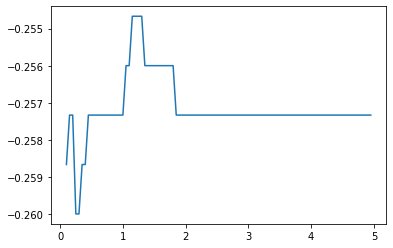

In [37]:
print(clf_gs.best_estimator_, '\nMSE:',-clf_gs.best_score_ )
print('\n')
pyplot.plot(n_range, clf_gs.cv_results_['mean_test_score'])

По результатам решетчетаго поиска и кросс-валидации, было установлено, что наилучшее качество модель достигает при С = 2.2. Необхдимо сравнить результаты с моделью, построенной раннее.

**Сравнение моделей**

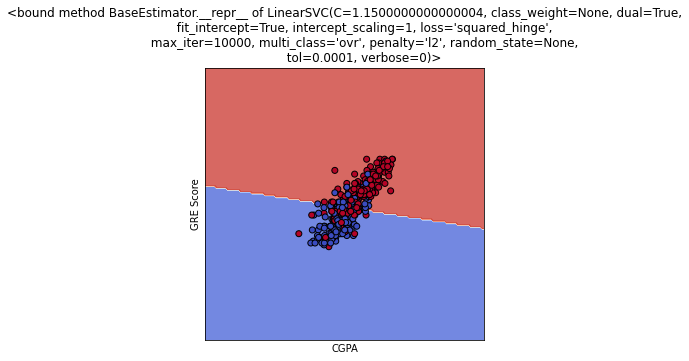


MSE: 0.23333333333333334
Accuracy: 0.7666666666666667
F1:  0.7904191616766467


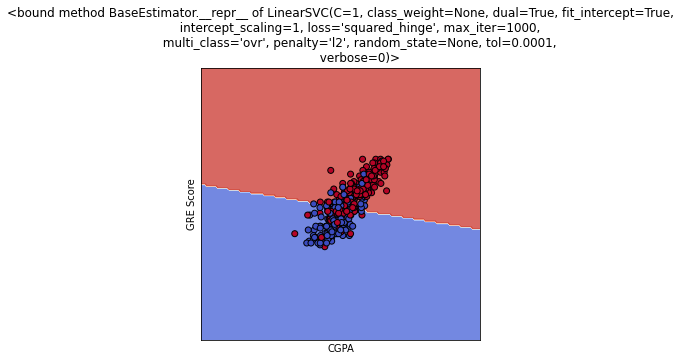


MSE: 0.23333333333333334
Accuracy: 0.7666666666666667
F1:  0.7904191616766467


In [38]:
from sklearn.metrics import accuracy_score, f1_score
plot_cl(clf_gs.best_estimator_)
y_predBest = clf_gs.best_estimator_.predict( np.array(X_test) )
print('\nMSE:',  mean_squared_error(y_test, y_predBest))
print('Accuracy:', accuracy_score(y_test, y_predBest))
print('F1: ', f1_score(y_test, y_predBest))
plot_cl(SvrModel)
y_predSvrModel = SvrModel.predict( np.array(X_test) )
print('\nMSE:',  mean_squared_error(y_test, y_predSvrModel))
print('Accuracy:', accuracy_score(y_test, y_predSvrModel))
print('F1: ', f1_score(y_test, y_predSvrModel))

**Вывод**: Метод SVR очень чувствителен к тестовой выборке - даже один случайный выброс может повлиять на результаты. На тестовых данных лучший результат показала модель, построенная с гиперпараметром С=1 (точность незначительно превосходит точность модели, построенной с использованием кросс-валидации). Однако, для решения поставленной задачи лучше использовать модель, полученную после кросс-валидации, так как она показала лучший результат на пяти различных тестовых выборках (С=0.25).


## Дерево решений

**Цель построения модели**: Классификация шансов на поступление кандидата (малые, средние и высокие шансы на поступление) по результатам всех входных данных (баллы бакалавриата, баллы за различные виды тестирования, рейтинг университета и тд.)

Для начала необходимо классифицировать данные из датасета. Каждому кандидату присвоить класс в зависимости от его шансов на поступление

In [39]:
data1['Chance of Admit'].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit, dtype: float64

Исходя из описательной статистики следует следующее: наибольший шанс на поступление = 0.97, наименьший = 0.34. Следующая классификация будет наиболее оптимальной:
* Наименьшие шансы: 0.30 - 0.60
* Средние шансы: 0.60 - 0.80
* Наибольшие шансы: 0.80 - 1.00


In [0]:
# Метод создания переменной класса
def createClassification( bottomLimit, middleLimit ):
  classes = []
  for val in data1['Chance of Admit'].values:
    if val <= bottomLimit:
      classes.append(1)
    else:
       if val <= middleLimit:
        classes.append(2)
       else:
        classes.append(3)
  return pd.DataFrame(data= np.c_[data1, classes], columns= np.append(data1.columns.values, 'Class'))

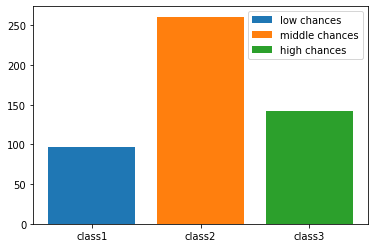

In [41]:
data4 = createClassification(0.6, 0.8)
data4 = data4.drop(['Chance of Admit'], axis=1)
ax0 = plt.subplot()
class1 = data4[data4['Class']==1].shape[0]
class2 = data4[data4['Class']==2].shape[0]
class3 = data4[data4['Class']==3].shape[0]
ax0.bar( 'class1', class1, label='low chances')
ax0.bar( 'class2', class2, label='middle chances')
ax0.bar( 'class3', class3, label='high chances')
ax0.legend()
plt.show()

In [42]:
data4.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Class
0,1.0,337.0,118.0,4.0,4.5,4.5,9.65,1.0,3.0
1,2.0,324.0,107.0,4.0,4.0,4.5,8.87,1.0,2.0
2,3.0,316.0,104.0,3.0,3.0,3.5,8.00,1.0,2.0
3,4.0,322.0,110.0,3.0,3.5,2.5,8.67,1.0,2.0
4,5.0,314.0,103.0,2.0,2.0,3.0,8.21,0.0,2.0


Таким образом, числовая перменная `Chance of Admit` была заменена категориальной перменной `Class`. Распределение по классам показало, что у большинства кандидатов имеются средние шансы на поступление, меньше кандидатов с выскоими, в меньшестве - кандидаты с низкими шансами.

**Построение модели**

Разделение выборки


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data4.loc[:, 'GRE Score':'Research'], \
                                                   data4['Class'], \
                                                   test_size=0.3, \
                                                   random_state=42)

Обучение модели с гиперпараметрами:
* max_depth=5 
* max_features=0.2
* min_samples_leaf=0.04

In [44]:
from sklearn.tree import DecisionTreeClassifier
testDTModel = DecisionTreeClassifier(random_state=1, max_depth=5, max_features=0.2, min_samples_leaf=0.04)
testDTModel.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.04, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

Оценка качества построенной модели

In [48]:
from sklearn.metrics import precision_score, recall_score

testDTModel_predict = testDTModel.predict(np.array(X_test))
print('F1: \t\t', f1_score(y_true= y_test, y_pred= testDTModel_predict, average= 'weighted'))
print('Precision: \t',precision_score(y_true= y_test, y_pred= testDTModel_predict, average= 'weighted') )
print('Recall: \t',recall_score(y_true= y_test, y_pred= testDTModel_predict , average= 'weighted') )
print('MSE: \t\t',mean_squared_error(y_true= y_test, y_pred= testDTModel_predict) )

F1: 		 0.7589341919969694
Precision: 	 0.762375478927203
Recall: 	 0.76
MSE: 		 0.24


## Задание 6. Произведите для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.

In [0]:
kf = ShuffleSplit(n_splits=5, test_size=0.3).split(data4.loc[:, 'GRE Score':'Research'], data4['Class'])

In [0]:
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}

In [51]:
grid_1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
                    param_grid= params, scoring='neg_mean_squared_error', cv=kf)
grid_1.fit(data4.loc[:, 'GRE Score':'Research'], data4['Class'])

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f7092fb7938>,
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6],
    

In [52]:
grid_1.best_estimator_, -grid_1.best_score_

(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=4, max_features=0.6, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=0.04, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1, splitter='best'), 0.1853333333333333)

В результате кросс-валидации и решетчатого поиска была найдена наилучшая модель со следующеми гиперпараметрами: 
*  max_depth=3
* max_features=0.8
* min_samples_leaf=0.08


## Задание 7. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

**Доп. задание.**
Рассмотрим распределение важности среди переменных в полученной модели.

In [0]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

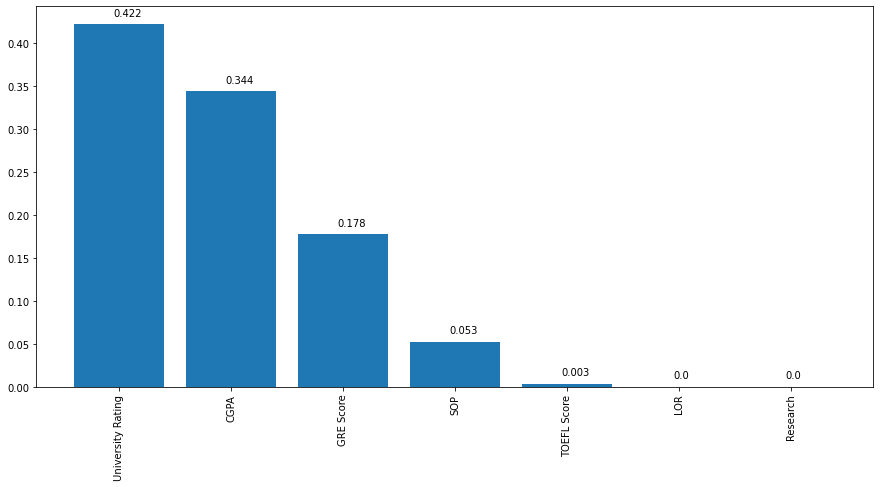

In [55]:
_1,_2 = draw_feature_importances(grid_1.best_estimator_, data4.loc[:, 'GRE Score':'Research'])

А также для модели, полученой раннее

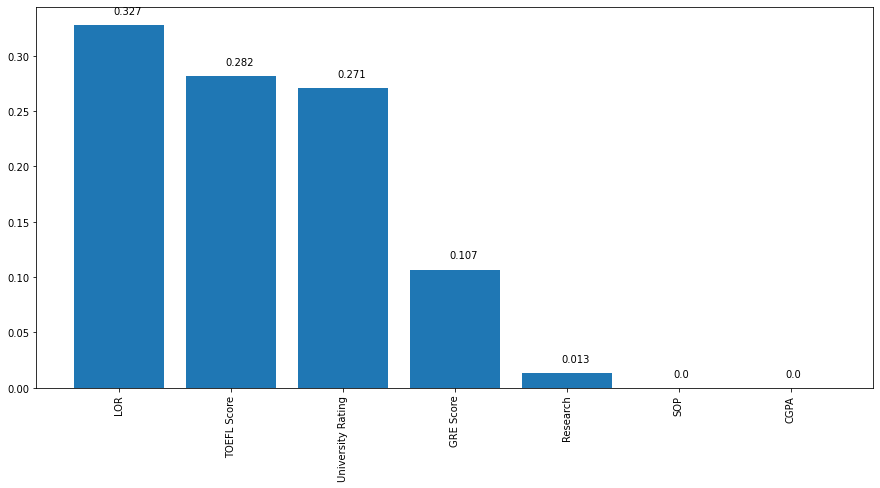

In [56]:
_1,_2 = draw_feature_importances(testDTModel, data4.loc[:, 'GRE Score':'Research'])

Для полноты сравнения, рассмотрим метрики качества для двух моделей

In [57]:
print('Test Descision Tree Model')
print('F1: \t\t', f1_score(y_true= y_test, y_pred= testDTModel_predict, average= 'weighted'))
print('Precision: \t',precision_score(y_true= y_test, y_pred= testDTModel_predict, average= 'weighted') )
print('Recall: \t',recall_score(y_true= y_test, y_pred= testDTModel_predict , average= 'weighted') )
print('MSE: \t\t',mean_squared_error(y_true= y_test, y_pred= testDTModel_predict) )
bestDTModel_predict = grid_1.best_estimator_.predict(np.array(X_test))
print('\nBest Descision Tree Model')
print('F1: \t\t', f1_score(y_true= y_test, y_pred= bestDTModel_predict, average= 'weighted'))
print('Precision: \t',precision_score(y_true= y_test, y_pred= bestDTModel_predict, average= 'weighted') )
print('Recall: \t',recall_score(y_true= y_test, y_pred= bestDTModel_predict , average= 'weighted') )
print('MSE: \t\t',mean_squared_error(y_true= y_test, y_pred= bestDTModel_predict) )

Test Descision Tree Model
F1: 		 0.7589341919969694
Precision: 	 0.762375478927203
Recall: 	 0.76
MSE: 		 0.24

Best Descision Tree Model
F1: 		 0.8245397093748742
Precision: 	 0.832561403508772
Recall: 	 0.8333333333333334
MSE: 		 0.16666666666666666
